In [1]:
import pandas as pd 
import numpy as np 

file = 'videotranscript.csv'
data = pd.read_csv(file)

data.head()

,Unnamed: 0,sentence,label
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence
1,1,"Born and raised in Houston, Texas, she perform...",sentence
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence
4,4,Following the disbandment of Destiny's Child i...,sentence


In [2]:
from sklearn.preprocessing import LabelEncoder

# Remove unnecessary index column
data.drop(columns=data.columns[0], inplace=True)

# Clean text: lowercasing, removing punctuation, and stripping whitespace
data['sentence'] = data['sentence'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

print(data.head())
print(data.shape)

                                            sentence  label
0  beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...      1
1  born and raised in houston texas she performed...      1
2  managed by her father mathew knowles the group...      1
3  their hiatus saw the release of beyoncés debut...      1
4  following the disbandment of destinys child in...      1
(235110, 2)


In [18]:
import joblib

# Save the LabelEncoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limiting to 10,000 features for manageability

# Fit and transform the sentences to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(data['sentence'])

# Display the shape of the resulting TF-IDF matrix and the type of features it has created
print(tfidf_matrix.shape)
print(tfidf_vectorizer.get_feature_names_out()[:100])  # Displaying the first 100 features for inspection


(235110, 10000)
['01' '02' '03' '05' '10' '100' '1000' '10000' '100000' '101930suser17'
 '1019adultsuser28' '1019adultsuser32' '1019adultsuser35' '102' '105'
 '106' '107' '10th' '11' '110' '1100' '1106adultsuser105' '110820suser21'
 '110840suser18' '110840suser7' '110920suser156' '110940suser18'
 '110940suser34' '110940suser52' '110940suser7' '114' '115' '11th' '12'
 '120' '1200' '12000' '125' '127' '128' '12th' '13' '130' '1300' '13th'
 '14' '1400' '1419teens' '1492' '14th' '15' '150' '1500' '15000' '150000'
 '15th' '16' '160' '1600' '1648' '16th' '17' '1700' '1700s' '1757' '1758'
 '1762' '1776' '1788' '1789' '1790' '1791' '1793' '1795' '17th' '18' '180'
 '1800' '1800s' '1801' '1808' '1810' '1812' '1814' '1815' '1817' '1820'
 '1821' '1822' '1824' '1825' '1829' '1830' '1831' '1832' '1833' '1834'
 '1835' '1836' '1837']


In [4]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD with a specific number of components to reduce the feature space
lsa = TruncatedSVD(n_components=300)  # You can adjust the number of components based on your specific needs

# Fit and transform the TF-IDF matrix using LSA
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Display the shape of the resulting LSA matrix and the amount of variance explained by the components
print(lsa_matrix.shape)
print(f"Explained variance ratio (cumulative): {sum(lsa.explained_variance_ratio_)}")


(235110, 300)
Explained variance ratio (cumulative): 0.29080739044987475


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert TF-IDF to a term-frequency matrix
tf_vectorizer = CountVectorizer(max_features=10000)
tf_matrix = tf_vectorizer.fit_transform(data['sentence'])

# Initialize LDA with a specified number of topics
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # You can adjust the number of topics

# Fit LDA model on the dataset
lda_matrix = lda.fit_transform(tf_matrix)

# Check the shape of the LDA matrix
print(lda_matrix.shape)


(235110, 10)


In [6]:
from gensim.models import Word2Vec
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize sentences
data['tokenized'] = data['sentence'].apply(word_tokenize)

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=data['tokenized'], vector_size=100, window=5, min_count=5, workers=4)

# Optionally, you can use a pre-trained model instead
# word2vec_model = api.load('word2vec-google-news-300')

# Explore the model
print(word2vec_model.wv.most_similar('example'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stormbreaker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('instance', 0.7486647963523865), ('ideal', 0.6622704267501831), ('explanation', 0.6369928121566772), ('amalgamation', 0.6254404187202454), ('expression', 0.6167770624160767), ('substitute', 0.6009918451309204), ('unknown', 0.595906674861908), ('alloy', 0.5931105017662048), ('abbreviation', 0.5892019867897034), ('jew', 0.5867902040481567)]


In [8]:

from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings
sentence_embeddings = model.encode(data['sentence'].tolist())

# Check the shape of the embeddings
print(sentence_embeddings.shape)


c:\Users\stormbreaker\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(235110, 384)


AUC Score: 0.9529620931625967


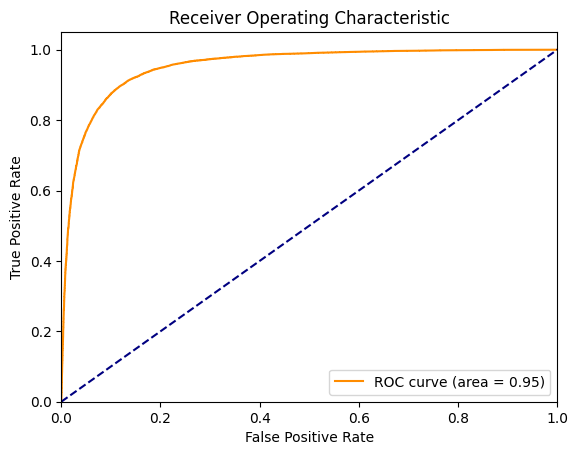

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, data['label'], test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Assuming 'data['tokenized']' contains the tokenized sentences
# Convert tokens to sequences of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tokenized'])
sequences = tokenizer.texts_to_sequences(data['tokenized'])
word_index = tokenizer.word_index

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=50)  # Adjust 'maxlen' based on your data

# Prepare labels
y = np.array(data['label'])

# Split into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=50))  # '100' is the embedding dimension
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/5
2939/2939 [==============================] - 438s 148ms/step - loss: 0.0643 - accuracy: 0.9777 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 2/5
2939/2939 [==============================] - 437s 149ms/step - loss: 0.0241 - accuracy: 0.9925 - val_loss: 0.0364 - val_accuracy: 0.9893
Epoch 3/5
2939/2939 [==============================] - 437s 149ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0361 - val_accuracy: 0.9894
Epoch 4/5
2939/2939 [==============================] - 432s 147ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0435 - val_accuracy: 0.9880
Epoch 5/5
2939/2939 [==============================] - 397s 135ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0464 - val_accuracy: 0.9891


In [15]:
# print the shape of X_test

print(X_test.shape)

(47022, 300)


1470/1470 [==============================] - 9s 6ms/step
ROC AUC Score: 0.9986879792607122


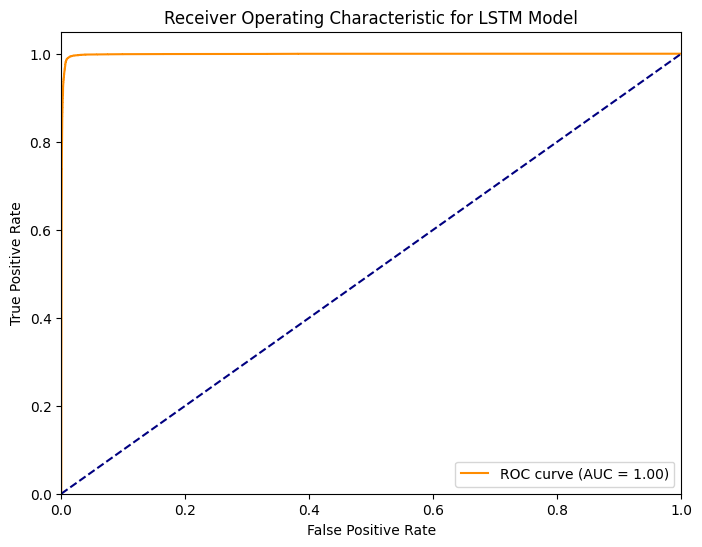

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming `model` is your trained LSTM model and `X_test_lstm` is correctly shaped

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test_lstm)

# Compute ROC AUC
auc_score = roc_auc_score(y_test_lstm, y_pred_probs)
print(f"ROC AUC Score: {auc_score}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM Model')
plt.legend(loc="lower right")
plt.show()



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 12.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


AUC Score: 0.9901663797159532


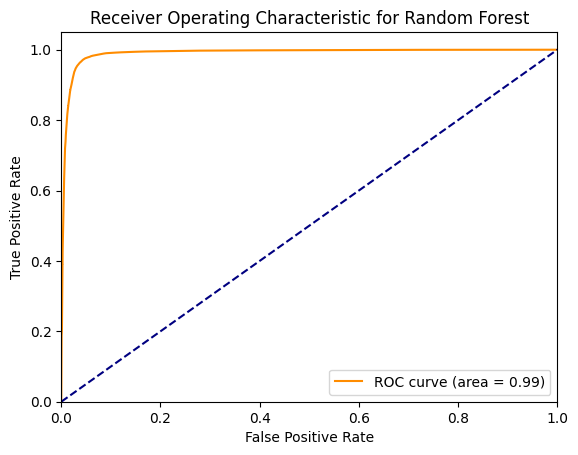

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

# Assuming data loading and preprocessing is done

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lsa_matrix, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier with verbose output
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)  # Verbose set to 1

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Predict probabilities for the test data
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()

